# [sxwOBA](https://sxwoba.herokuapp.com/) - spray-angle enhanced xwOBA
---

#### What is sxwOBA?
At its core sxwOBA is simply a variation of the popular metric xwOBA. Using three inputs--launch angle, exit velocity, and spray angle--

#### What is wOBA?
---

wOBA (weighted on-base average) is a baseball statistic created by [Tom Tango](http://www.tangotiger.com/index.php) that uses linear weights to measure a player's overall offensive contributions in the form of a rate stat. It is calculated by assigning a weight to each type of offensive event (e.g. single, double, home run, etc.) proportional to their average run values, and then summing the weights for all of a player's offensive events. wOBA can be calculated for any given player's 2022 season by using the following formula (uBB stands for unintentional walks):

$$ \text{wOBA} = \frac{0.69 \cdot \text{uBB} + 0.72 \cdot \text{HBP} + 0.88 \cdot \text{1B} + 1.26 \cdot \text{2B} + 1.60 \cdot \text{3B} + 2.07 \cdot \text{HR} }{\text{AB + BB + SF + HBP - IBB }} $$

wOBA is a more accurate representation of a hitter's contribution to scoring than other metrics such as On-base percentage (**OBP**) and Slugging percentage (**SLG**).
- OBP does not differentiate between different ways of getting on base. A walk is treated equally to a home run.
- SLG inaccurately treats home runs as having four times the value of a single. It also ignores walks altogether.
- On-base plus slugging (OPS) attempts to alleviate the deficiencies of each of these metrics by simply adding them together into one metric, however this is a quick and dirty estimate of run production that improves upon, but **does not** fix the deficiencies of each of the two metrics. It is still inaccurately weighting the value of each hit type, and overvalues the role of SLG in run production.

> *wOBA is conveniently scaled the same as on-base percentage. Therefore, **league-average wOBA is equivalent to league-average OBP** allowing the metric to be easily understood by those familar to OBP.*

More info:
- [Season-by-season linear weights](https://www.fangraphs.com/guts.aspx?type=cn)
- [Calculating linear weights yourself](http://www.insidethebook.com/ee/index.php/site/article/woba_year_by_year_calculations/)
- [wOBA - Fangraphs glossary](https://library.fangraphs.com/offense/woba/)


---
#### What is xwOBA?
---

xwOBA or expected weighted on-base average takes a different approach from wOBA. Rather than crediting hitting outcomes with their linear weights, it credits hitters based on contact quality (specifically exit velocity, launch angle, and&mdash;on some ground balls&mdash;sprint speed). 

Evaluating a hitter's skill based on the quality of their contact with the ball provides a more accurate representation of their abilities because it takes into account the factors that the hitter can control.. On the other hand, the focus on outcomes in wOBA leaves room for variance caused by defense, ballpark dimensions, weather conditions, and other factors that may be attributed to luck. 

For example let's compare two doubles. One is a ground ball down the foul line that is just out of reach of the defender and rolls past the baseinto foul territory, the other is a scorched line drive that shoots past the outfielder's head and bounces on the warning track. wOBA credits each of these doubles equally, because it only recognizes outcomes. xwOBA  ignores the outcome and instead credits each batted ball based on the results of previous, similar batted balls.

More info:
- [Baseball-Savant xwOBA Leaderboards](https://baseballsavant.mlb.com/leaderboard/expected_statistics)
- [xwOBA Definition - MLB.com glossary](https://www.mlb.com/glossary/statcast/expected-woba)



---
#### Where does sxwOBA come in?
---

sxwOBA is a simple variation of xwOBA with the incorporation of spray angle. Spray angle, not to be confused with launch angle, simply corresponds to the horizontal direction of a batted ball. In other words spray angle, which is measured in degrees, tells us the degree to which the batted ball is pulled or to the opposite field.

> *The transformed variable **theta_deg** in my python code measures this angle from home plate with 0 degrees corresponding to the right-field foul line and 90 degrees corresponding to the left-field foul line.*

With its inclusion in the model, we are making the assumption that, like exit velocity and launch angle, hitters also have some degree of control over their spray angle.

---
#### Do hitters have control over their spray angle?
---
While it may seem obvious that hitters have some control over the spray angle&mdash;a simple look at Marcus Semien's 2021 spray chart should be pretty convincing&mdash;it's important to test these assumptions and evaluate the degree of consistency in spray profiles hitters have from year to year. If a hitter cannot maintain a pull-heavy profile into the next season, is it even worth including spray angle into the expected wOBA model?

To understand the degree to which hitters have control over their spray angle I measured the predictive performance by means of $\mathit{R}^2$ to measure the proportion of variance of a hitter's pull rate that could be explained by the hitter's pull rate in the previous season . I looked at 2018-2022, setting a minimum yearly PA requirement of 450 (2020 was therefore excluded). (*There are some drawbacks to this methodology: namely there is some selection bias, as the PA requirement limited the sample of hitters to 49)

|Season|2018|2019|2021|2022|
|------|----|----|----|----|
|2018  |1   |0.39|0.38|0.23|
|2019  |-   |1   |0.29|0.18|
|2021  |-   |-   |1   |0.57|
|2022  |-   |-   |-   |1   |

Hitter's pull rates in a previous year were predictive of their pull rates in the next year, but the predictiveness began to decline when predicting pull rates based on data that was older than the previous year. Interestingly, pull rates in 2021 predicted hitters pull rates in 2022 much more accurately than those from 2018 did for 2019. This may indicate that hitters have gained more control over influencing their spray angle.





In [81]:
import pandas as pd
import numpy as np
import pybaseball as pb
import matplotlib.pyplot as plt

In [7]:
df = pb.statcast("2022-04-01", "2022-10-02")

This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████| 185/185 [00:32<00:00,  5.73it/s]


In [8]:
df.shape

(709530, 92)

In [9]:
pd.set_option("display.max_columns", None)
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
2691,FF,2022-10-02,93.5,1.7,5.95,"Zastryzny, Rob",663993,642239,strikeout,foul_tip,<NA>,<NA>,<NA>,<NA>,1,Nathaniel Lowe strikes out on a foul tip.,R,L,L,LAA,TEX,S,2,None,2,2,2022,0.28,1.45,-0.76,3.38,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,681351,<NA>,<NA>,-6.991996,-136.147176,-4.189087,4.82307,26.459023,-13.32925,3.36,1.56,<NA>,<NA>,<NA>,94.6,2451,6.6,663419,642239,681351,622110,664058,650859,670869,666176,545361,621493,53.88,<NA>,<NA>,0.0,1,0,0,<NA>,78,6,4-Seam Fastball,8,3,3,8,3,8,3,8,Standard,Standard,167,0.0,-0.083
2856,CU,2022-10-02,80.9,2.06,5.59,"Zastryzny, Rob",663993,642239,None,ball,<NA>,<NA>,<NA>,<NA>,13,Nathaniel Lowe strikes out on a foul tip.,R,L,L,LAA,TEX,B,<NA>,None,1,2,2022,-1.12,-0.08,-0.66,0.49,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,681351,<NA>,<NA>,-3.954146,-117.715311,-4.559455,-9.519474,23.798909,-32.179781,3.48,1.57,<NA>,<NA>,<NA>,81.1,2266,6.5,663419,642239,681351,622110,664058,650859,670869,666176,545361,621493,53.95,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,78,5,Curveball,8,3,3,8,3,8,3,8,Standard,Standard,273,0.0,0.014
2921,FF,2022-10-02,92.3,1.65,5.93,"Zastryzny, Rob",663993,642239,None,foul,<NA>,<NA>,<NA>,<NA>,2,Nathaniel Lowe strikes out on a foul tip.,R,L,L,LAA,TEX,S,<NA>,None,1,2,2022,0.28,1.58,-0.2,3.12,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,681351,<NA>,<NA>,-5.363762,-134.219794,-4.773044,4.61046,29.36333,-12.270475,3.36,1.56,<NA>,<NA>,<NA>,92.8,2321,6.7,663419,642239,681351,622110,664058,650859,670869,666176,545361,621493,53.84,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,78,4,4-Seam Fastball,8,3,3,8,3,8,3,8,Standard,Standard,157,0.0,0.0
3122,FF,2022-10-02,94.3,1.65,5.93,"Zastryzny, Rob",663993,642239,None,ball,<NA>,<NA>,<NA>,<NA>,12,Nathaniel Lowe strikes out on a foul tip.,R,L,L,LAA,TEX,B,<NA>,None,0,2,2022,0.4,1.44,0.53,3.69,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,681351,<NA>,<NA>,-3.821913,-137.326774,-3.300921,5.982245,32.139379,-13.477013,3.46,1.56,<NA>,<NA>,<NA>,94.4,2391,6.4,663419,642239,681351,622110,664058,650859,670869,666176,545361,621493,54.09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,78,3,4-Seam Fastball,8,3,3,8,3,8,3,8,Standard,Standard,159,0.0,0.011
3142,FF,2022-10-02,93.4,1.81,5.93,"Zastryzny, Rob",663993,642239,None,called_strike,<NA>,<NA>,<NA>,<NA>,7,Nathaniel Lowe strikes out on a foul tip.,R,L,L,LAA,TEX,S,<NA>,None,0,1,2022,0.3,1.5,-0.62,2.19,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,681351,<NA>,<NA>,-6.894633,-135.687781,-7.160592,5.192353,30.297754,-12.18814,3.48,1.61,<NA>,<NA>,<NA>,93.3,2446,6.4,663419,642239,681351,622110,664058,650859,670869,666176,545361,621493,54.13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,78,2,4-Seam Fastball,8,3,3,8,3,8,3,8,Standard,Standard,156,0.0,-0.023


According to Fangraphs, there were 182,052 total plate appearances in 2022. In order to calculate run expectancy, we need to subset our data to include only pitches that conclude a plate appearance and change the game state. Luckily the ***events*** column can help us with this. The resulting dataframe should include 182,052 observations to match the total amount of plate appearances.

Looking at the unique events below, some do not correspond to a plate appearance (e.g. a runner is caught stealing, picked off, or advances on a wild pitch) We must also remove these events from our dataset.

In [11]:
df.events.unique()

array(['strikeout', None, 'field_out', 'grounded_into_double_play',
       'walk', 'single', 'double_play', 'double', 'home_run',
       'hit_by_pitch', 'force_out', 'field_error', 'triple', 'sac_fly',
       'fielders_choice_out', 'sac_bunt', 'caught_stealing_2b',
       'fielders_choice', 'strikeout_double_play', 'catcher_interf',
       'caught_stealing_3b', 'other_out', 'pickoff_caught_stealing_2b',
       'triple_play', 'caught_stealing_home', 'sac_fly_double_play',
       'wild_pitch', 'pickoff_1b', 'pickoff_caught_stealing_home',
       'pickoff_caught_stealing_3b', 'pickoff_3b', 'game_advisory',
       'pickoff_2b'], dtype=object)

In [16]:
df.events.notnull().sum()

183840

In [21]:
df.woba_denom.notnull().sum()

177931

In [18]:
non_pa = ['caught_stealing_2b', 'caught_stealing_3b', 'pickoff_caught_stealing_2b',
          'caught_stealing_home', 'wild_pitch', 'pickoff_1b', 'pickoff_caught_stealing_home',
          'pickoff_caught_stealing_3b', 'pickoff_3b', 'game_advisory', 'pickoff_2b', 'catcher_interf']


In [19]:
df.loc[(~df['events'].isin(non_pa)) & (df['events'].notnull())].shape

(183495, 92)

In [110]:
QUAL=500
df_18 = pb.batting_stats(2018, qual=QUAL)
df_19 = pb.batting_stats(2019, qual=QUAL)
df_21 = pb.batting_stats(2021, qual=QUAL)
df_22 = pb.batting_stats(2022, qual=QUAL)

In [111]:
batting = pd.concat([df_18, df_19, df_21, df_22])

In [112]:
pull_rates = pd.pivot_table(batting, values='Pull%', index='Name', columns='Season')

In [113]:
pull_rates

Season,2018,2019,2021,2022
Name,,,,
A.J. Pollock,0.486,NaN,NaN,0.438
Aaron Hicks,0.454,NaN,NaN,0.475
Aaron Judge,0.402,NaN,0.363,0.475
Adam Duvall,NaN,NaN,0.474,NaN
Adam Eaton,NaN,0.328,NaN,NaN
...,...,...,...,...
Yoan Moncada,0.414,0.396,0.384,NaN
Yolmer Sanchez,0.373,0.314,NaN,NaN
Yonder Alonso,0.437,NaN,NaN,NaN


In [114]:
pull_rates.corr()

Season,2018,2019,2021,2022
Season,,,,
2018,1.000000,0.638928,0.584738,0.433549
2019,0.638928,1.000000,0.500072,0.442852
2021,0.584738,0.500072,1.000000,0.732036
2022,0.433549,0.442852,0.732036,1.000000


In [115]:
pull_rates = pull_rates.dropna()

In [141]:
def r_squared(season1, season2, min_pa):
    """
    season1: int (YYYY format)
    season2: int (YYYY format)
    
    Returns  the proportion of the variance in the dependent variable
    (season2 pull rate) that is explained by the independent variable (season1 pull rate).
    """
    try:
        df1 = pb.batting_stats(season1, qual=min_pa)
        df2 = pb.batting_stats(season2, qual=min_pa)
    except:
        if season1 == 2018:
            print("using {} mininum PA".format(QUAL))
            df1 = df_18.copy()
        elif season
    batting = pd.concat([df1, df2])
    df = pd.pivot_table(batting, values='Pull%', index='Name', columns='Season').dropna()
    
    from scipy.stats import linregress
    x = df[season1]
    y = df[season2]
    _slope, _intercept, r_value, _p_value, _std_err = linregress(x, y)
    r2 = r_value**2
    print("The R^2 from {} to {} is {.2f}".format(season1, season2, r2))
    return r2
    



In [142]:
r_squared(2021, 2022, min_pa=500)

The R^2 from 2021 to 2022 is 0.5121713209520136


0.5121713209520136

In [148]:
r_squared(pull_rates, 2018, 2019)

HTTPError: Error accessing 'https://www.fangraphs.com/leaders.aspx'. Received status code 500

In [147]:
r_squared(pull_rates, 2021, 2022)

HTTPError: Error accessing 'https://www.fangraphs.com/leaders.aspx'. Received status code 500

In [125]:
def plot_normal(df, season, row, col):
    from scipy.stats import norm
    
    data = df[season]
    mean = data.mean()
    std = data.std()
    
    x = np.linspace(mean - (3*std), mean + (3*std), 100)
    y = norm.pdf(x, mean, std)
    norm_plot = ax[row, col].plot(x, y, 'black', linewidth=2)
    

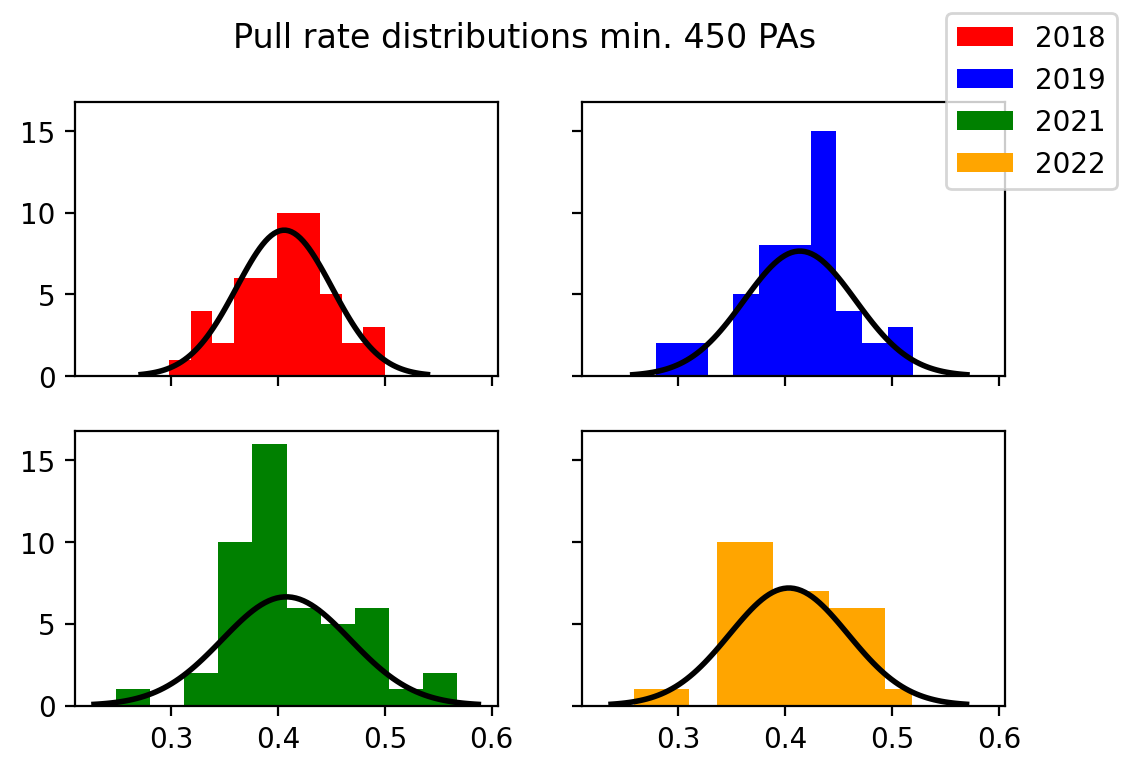

In [134]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, dpi=200)
ax[0,0].hist(pull_rates[2018], label='2018', color='red')
ax[0,1].hist(pull_rates[2019], label='2019', color='blue')
ax[1,0].hist(pull_rates[2021], label='2021', color='green')
ax[1,1].hist(pull_rates[2022], label='2022', color='orange')

plot_normal(pull_rates, 2018, 0, 0)
plot_normal(pull_rates, 2019, 0, 1)
plot_normal(pull_rates, 2021, 1, 0)
plot_normal(pull_rates, 2022, 1, 1)

fig.legend()
fig.suptitle("Pull rate distributions min. {} PAs".format(QUAL))
plt.show()

In [122]:
pull_rates.shape

(49, 4)

In [123]:
help(plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots.
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:
    
        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.
    
        When subplots have a shared x-axis along a column, on